
SumSquares: 2D


In [ ]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=190b7659cd4936417ee5b90b21c267a8c095cf5dc6a63826f8e437b04e867d32
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [ ]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
### Inputs:

func = 'SumSquares'
n_test = 500
eps = 1e-08

util_grad_exact = 'dERM_GP'
util_grad_approx = 'ExpectedRegret'

n_init = 5 # random initialisations
iters = 20
opt = True

In [ ]:
### Objective Function - Sum Squares(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * (  1 * x1_training ** 2
                            + 2 * x2_training ** 2
                            )
        
# Constraints:
lb = -10
ub = +10
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))


In [ ]:
n_start_AcqFunc = iters


In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [ ]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds
        

In [ ]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ExpectedRegret': self.ExpectedRegret,
            'dERM_GP': self.dERM_GP
        }

        self.f = mode_dict[mode]
    
    def ExpectedRegret(self, tau, mean, std):
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (mean - y_global_orig) * norm.cdf(z) + std * norm.pdf(z)[0]


    def dERM_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [ ]:
## GPGO_multi: Multistart changed to variable 'n_start_AcqFunc'

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        if self.n_jobs == 1:
            for index, start_point in enumerate(start_points_arr):
                res = minimize(self._acqWrapper, x0=start_point, method=method,
                               bounds=self.parameter_range)
                x_best[index], f_best[index] = res.x, np.atleast_1d(res.fun)[0]
        else:
            opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
            x_best = np.array([res.x for res in opt])
            f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]

In [ ]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [ ]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
start_approx = time.time()
start_approx


1637145829.8150449

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_new(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65955991  4.40648987]. 	  -41.5884450098667 	 -5.468172821636052
init   	 [-9.9977125  -3.95334855]. 	  -131.21218477957908 	 -5.468172821636052
init   	 [-7.06488218 -8.1532281 ]. 	  -182.86281732102734 	 -5.468172821636052
init   	 [-6.27479577 -3.08878546]. 	  -58.4542532110911 	 -5.468172821636052
init   	 [-2.06465052  0.77633468]. 	  -5.468172821636052 	 -5.468172821636052
1      	 [ 7.89213327 -8.29911577]. 	  -200.03641276683908 	 -5.468172821636052
2      	 [7.66612182 2.47344414]. 	  -71.00527566059496 	 -5.468172821636052
3      	 [1.62717855 9.40039978]. 	  -179.3827421328839 	 -5.468172821636052
4      	 [-9.56950389  8.95940422]. 	  -252.11725289788865 	 -5.468172821636052
5      	 [ 2.56152397 -4.28847437]. 	  -43.34342980630102 	 -5.468172821636052
6      	 [  1.1169921 -10.       ]. 	  -201.2476713447619 	 -5.468172821636052
7      	 [-7.49060555  3.35024517]. 	  -78.55745694801789 	 -5.468172821636

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_new(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.28010196 -9.48147536]. 	  -181.43541115584648 	 -4.333099000920773
init   	 [ 0.99324956 -1.29355215]. 	  -4.333099000920773 	 -4.333099000920773
init   	 [-1.59264396 -3.39330358]. 	  -25.565533148780872 	 -4.333099000920773
init   	 [-5.90702732  2.38541933]. 	  -46.27342248166184 	 -4.333099000920773
init   	 [-4.00690653 -4.6634545 ]. 	  -59.55091562094812 	 -4.333099000920773
1      	 [4.01504693 9.2910216 ]. 	  -188.7667666769868 	 -4.333099000920773
2      	 [ 9.4582138 -7.7444757]. 	  -209.411615827435 	 -4.333099000920773
3      	 [ 9.07319925 -1.03970567]. 	  -84.48492034594878 	 -4.333099000920773
4      	 [-9.13741927 -7.85625192]. 	  -206.93381928482216 	 -4.333099000920773
5      	 [9.90347629 4.73174783]. 	  -142.85771782951963 	 -4.333099000920773
6      	 [-3.25263411  9.0402141 ]. 	  -174.03057068772284 	 -4.333099000920773
7      	 [-9.01290675  7.88655796]. 	  -205.6280811546718 	 -4.333099000920

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_new(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.01595805 4.16295645]. 	  -35.692583610916834 	 -17.582120911078754
init   	 [-4.18190522  0.2165521 ]. 	  -17.582120911078754 	 -17.582120911078754
init   	 [7.85893909 7.92586178]. 	  -187.4014934415638 	 -17.582120911078754
init   	 [-7.48829379 -5.85514244]. 	  -124.63992981683481 	 -17.582120911078754
init   	 [-8.97065593 -1.18380313]. 	  -83.2754475728413 	 -17.582120911078754
1      	 [ 5.60629529 -3.87272935]. 	  -61.42661215628989 	 -17.582120911078754
2      	 [-8.52752662  7.84786375]. 	  -195.89664111179286 	 -17.582120911078754
3      	 [-0.35005916 -4.25900471]. 	  -36.40078359655554 	 -17.582120911078754
4      	 [9.55904819 0.05502095]. 	  -91.38145696941282 	 -17.582120911078754
5      	 [ 1.26866936 10.        ]. 	  -201.60952194488695 	 -17.582120911078754
6      	 [ 9.91572611 -9.01887335]. 	  -261.00177731356047 	 -17.582120911078754
7      	 [-2.10496259 -9.55536227]. 	  -187.04076369171705 	 -1

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_new(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.34059678 0.94464498]. 	  -89.0314565014143 	 -27.80880071439404
init   	 [9.4536872  4.29631987]. 	  -126.28893057280868 	 -27.80880071439404
init   	 [ 3.95457649 -5.67821009]. 	  -80.12281484649141 	 -27.80880071439404
init   	 [ 9.5254891 -9.8753949]. 	  -285.78179120922215 	 -27.80880071439404
init   	 [-4.94035275 -1.30416935]. 	  -27.80880071439404 	 -27.80880071439404
1      	 [-6.35109191  8.36766078]. 	  -180.3718623830372 	 -27.80880071439404
2      	 [1.43282743 6.87413988]. 	  -96.56059262521096 	 -27.80880071439404
3      	 [ -1.01718283 -10.        ]. 	  -201.03466091024856 	 -27.80880071439404
4      	 [-10.           1.63643071]. 	  -105.35581092429686 	 -27.80880071439404
5      	 [6.76296991 9.58289924]. 	  -229.40167778295262 	 -27.80880071439404
6      	 [1.38816048 0.71187876]. 	  -2.9405322508945897 	 -2.9405322508945897
7      	 [-9.17779306 -4.93993421]. 	  -133.03778559310527 	 -2.94053225089

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_new(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.56013658  7.41464612]. 	  -140.86907304317228 	 -10.04307293518387
init   	 [-5.86561689  8.37221816]. 	  -174.59353533361667 	 -10.04307293518387
init   	 [-0.23177622  2.23487726]. 	  -10.04307293518387 	 -10.04307293518387
init   	 [5.31815713 0.36835976]. 	  -28.554173077012745 	 -10.04307293518387
init   	 [-4.06398997 -6.24557543]. 	  -94.53043928694063 	 -10.04307293518387
1      	 [9.27861058 9.20453431]. 	  -255.5395178906315 	 -10.04307293518387
2      	 [ 8.87080164 -7.76615146]. 	  -199.31733862713008 	 -10.04307293518387
3      	 [0.54357666 9.2242228 ]. 	  -170.4680482407008 	 -10.04307293518387
4      	 [ 2.49508934 -6.80638133]. 	  -98.87912454627462 	 -10.04307293518387
5      	 [-10.          -5.51410504]. 	  -160.81070873939112 	 -10.04307293518387
6      	 [-8.62367183  0.50898962]. 	  -74.88585667581904 	 -10.04307293518387
7      	 [10.          3.37456894]. 	  -122.77543106733403 	 -10.0430729

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_new(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.85720303 -3.36040389]. 	  -84.32026809583151 	 -5.629416961321397
init   	 [ 6.42458246 -9.16606749]. 	  -209.30884609749882 	 -5.629416961321397
init   	 [-7.8468664   1.90104128]. 	  -68.80122824744078 	 -5.629416961321397
init   	 [ 0.59634724 -1.62385143]. 	  -5.629416961321397 	 -5.629416961321397
init   	 [-3.29184301  2.45038864]. 	  -22.84503944485431 	 -5.629416961321397
1      	 [4.34664291 8.74699069]. 	  -171.91299695999675 	 -5.629416961321397
2      	 [-4.96771714 -9.17248997]. 	  -192.94735819477367 	 -5.629416961321397
3      	 [9.57427611 1.74148842]. 	  -97.73232691305284 	 -5.629416961321397
4      	 [-5.6935267   8.60486508]. 	  -180.50365249520243 	 -5.629416961321397
5      	 [3.70615819 2.88302382]. 	  -30.359261199656586 	 -5.629416961321397
6      	 [-8.88129971 -3.75034449]. 	  -107.00765218794083 	 -5.629416961321397
7      	 [-0.45748598  7.70980473]. 	  -119.09147150685489 	 -5.629416961

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_new(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.47383421  5.59837584]. 	  -134.48949046062052 	 -21.448213419349443
init   	 [-1.23181537  4.46930356]. 	  -41.46671767109191 	 -21.448213419349443
init   	 [9.55979024 0.76991741]. 	  -92.57513506242564 	 -21.448213419349443
init   	 [ 0.02240927 -8.55897733]. 	  -146.51268814245697 	 -21.448213419349443
init   	 [-4.63122040e+00 -2.34998349e-03]. 	  -21.448213419349443 	 -21.448213419349443
1      	 [ 8.12846538 -6.39096762]. 	  -147.76088362344177 	 -21.448213419349443
2      	 [6.00958098 8.78222707]. 	  -190.37008833601834 	 -21.448213419349443
3      	 [-9.10467478 -9.8356699 ]. 	  -276.3759076385656 	 -21.448213419349443
4      	 [-7.86246511 -2.61028169]. 	  -75.44549865130998 	 -21.448213419349443
5      	 [3.74742604 0.87382913]. 	  -15.570356662761933 	 -15.570356662761933
6      	 [-3.1239147   9.75028194]. 	  -199.89483890589167 	 -15.570356662761933
7      	 [-0.0500435  -2.86050177]. 	  -16.3674451436

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_new(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.46858806 9.37081326]. 	  -231.40408972112363 	 -0.5791878792948744
init   	 [7.3838908  0.61711383]. 	  -55.28350237060649 	 -0.5791878792948744
init   	 [-5.34543344 -9.77202391]. 	  -219.5585614355461 	 -0.5791878792948744
init   	 [-1.39062363 -1.9529728 ]. 	  -9.562039601098967 	 -0.5791878792948744
init   	 [ 0.45349343 -0.43216408]. 	  -0.5791878792948744 	 -0.5791878792948744
1      	 [ 9.69498875 -9.42535902]. 	  -271.6675921188219 	 -0.5791878792948744
2      	 [-9.83383251  5.77166529]. 	  -163.3285022998636 	 -0.5791878792948744
3      	 [-3.97152767  9.51013426]. 	  -196.65833950916016 	 -0.5791878792948744
4      	 [-9.65586204 -5.07440767]. 	  -144.73489822426617 	 -0.5791878792948744
5      	 [1.10947828 5.5318851 ]. 	  -62.4344475515165 	 -0.5791878792948744
6      	 [ 3.77011518 -4.40569277]. 	  -53.034026014752534 	 -0.5791878792948744
7      	 [  1.33298478 -10.        ]. 	  -201.77684843349064 	 -

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_new(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-9.79251692  0.03749184]. 	  -95.896198949837 	 -53.418783741178075
init   	 [-0.08453414 -7.32340942]. 	  -107.27179711012016 	 -53.418783741178075
init   	 [-7.15777829 -5.62882649]. 	  -114.6011653140891 	 -53.418783741178075
init   	 [-1.62983639 -5.03797663]. 	  -53.418783741178075 	 -53.418783741178075
init   	 [-8.31880698 -3.0900272 ]. 	  -88.29908569649677 	 -53.418783741178075
1      	 [6.0747954  9.66718496]. 	  -223.8120694300478 	 -53.418783741178075
2      	 [-3.94738717  9.4159639 ]. 	  -192.90261763630335 	 -53.418783741178075
3      	 [4.07561386 0.71776482]. 	  -17.64100099927903 	 -17.64100099927903
4      	 [ 8.66970884 -6.33785621]. 	  -155.50069423954056 	 -17.64100099927903
5      	 [-1.19250765  3.24798733]. 	  -22.52091788262156 	 -17.64100099927903
6      	 [10.          0.63541414]. 	  -100.8075022541351 	 -17.64100099927903
7      	 [-9.63856619  7.6177572 ]. 	  -208.9624076098196 	 -17.6410

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_new(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.42641287 -9.58496101]. 	  -213.18891181932327 	 -56.66743785259343
init   	 [2.6729647  4.97607765]. 	  -56.66743785259343 	 -56.66743785259343
init   	 [-0.02985975 -5.50406709]. 	  -60.59040065376497 	 -56.66743785259343
init   	 [-6.0387427   5.21061424]. 	  -90.76741505398337 	 -56.66743785259343
init   	 [-6.61778327 -8.23320372]. 	  -179.36634226756874 	 -56.66743785259343
1      	 [ 7.13700605 -2.96694721]. 	  -68.54240685564316 	 -56.66743785259343
2      	 [2.11155129 0.26933255]. 	  -4.603728884330075 	 -4.603728884330075
3      	 [-7.90760511 -1.20789524]. 	  -65.44824041188056 	 -4.603728884330075
4      	 [-4.25638812  9.80221347]. 	  -210.283617571058 	 -4.603728884330075
5      	 [9.49624999 3.61148749]. 	  -116.26444759812676 	 -4.603728884330075
6      	 [9.26715011 9.50785434]. 	  -266.67865967653205 	 -4.603728884330075
7      	 [-2.74553241  0.60885862]. 	  -8.279365876019959 	 -4.603728884330075

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_new(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.39460622 -9.61049517]. 	  -225.61422357508457 	 -2.716881462565864
init   	 [-0.73562947  4.49867858]. 	  -41.01736871863572 	 -2.716881462565864
init   	 [-1.59592791 -0.29145804]. 	  -2.716881462565864 	 -2.716881462565864
init   	 [-9.74438371 -0.25256785]. 	  -95.08059489374317 	 -2.716881462565864
init   	 [8.83613305 7.01590179]. 	  -176.5230030066306 	 -2.716881462565864
1      	 [ 1.99086793 -8.88652641]. 	  -161.90425830617428 	 -2.716881462565864
2      	 [ 6.89877062 -3.95670624]. 	  -78.9040846386408 	 -2.716881462565864
3      	 [  9.77656535 -10.        ]. 	  -295.58123009301335 	 -2.716881462565864
4      	 [-6.50299346  4.89457725]. 	  -90.20269683532382 	 -2.716881462565864
5      	 [0.0385348 9.4899039]. 	  -180.1180369987594 	 -2.716881462565864
6      	 [5.24860912 2.85966119]. 	  -43.90322199383101 	 -2.716881462565864
7      	 [-5.24921908 -3.83688198]. 	  -56.99762762300915 	 -2.71688146256586

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_new(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.91674315  4.80099393]. 	  -93.94042127407329 	 -23.318590147261595
init   	 [-4.7336997   0.67478787]. 	  -23.318590147261595 	 -23.318590147261595
init   	 [-9.70850075  8.37494016]. 	  -234.53423225249676 	 -23.318590147261595
init   	 [ 8.01429708 -9.33157145]. 	  -238.38540908259807 	 -23.318590147261595
init   	 [ 9.13898673 -7.25581357]. 	  -188.8147395776428 	 -23.318590147261595
1      	 [4.66251955 4.05244711]. 	  -54.583743654491954 	 -23.318590147261595
2      	 [-3.75432006 -8.6025265 ]. 	  -162.1018436659056 	 -23.318590147261595
3      	 [ 0.87886819 -1.89091226]. 	  -7.923507634979323 	 -7.923507634979323
4      	 [0.62006076 8.91956245]. 	  -159.50166406148657 	 -7.923507634979323
5      	 [ 8.15269188 -0.957369  ]. 	  -68.2994957298121 	 -7.923507634979323
6      	 [9.82022544 8.00293105]. 	  -224.53063835529863 	 -7.923507634979323
7      	 [ 2.19678836 -7.64250659]. 	  -121.6416931867226 	 -7.9235

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_new(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.55404821 -5.2491756 ]. 	  -85.95514048001408 	 -47.45541115581226
init   	 [6.48557065 9.31498396]. 	  -215.600479080162 	 -47.45541115581226
init   	 [ 9.45202228 -0.93101505]. 	  -91.0743031984701 	 -47.45541115581226
init   	 [2.18084926 5.51053029]. 	  -65.48799167425372 	 -47.45541115581226
init   	 [2.8322669  4.44036459]. 	  -47.45541115581226 	 -47.45541115581226
1      	 [-8.69830926  2.59657998]. 	  -89.14503917528086 	 -47.45541115581226
2      	 [-5.9673185  -6.48540274]. 	  -119.72978734259729 	 -47.45541115581226
3      	 [-0.60899509 -1.54249972]. 	  -5.129485779327708 	 -5.129485779327708
4      	 [-5.68974606  9.11900061]. 	  -198.68555458020188 	 -5.129485779327708
5      	 [ 10. -10.]. 	  -300.0 	 -5.129485779327708
6      	 [ 0.15011013 -7.2604606 ]. 	  -105.45110920148105 	 -5.129485779327708
7      	 [-3.0447625   3.58748022]. 	  -35.010607380285535 	 -5.129485779327708
8      	 [10.          4

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_new(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.27886688 5.46330104]. 	  -59.77308327621332 	 -26.48525945153859
init   	 [ 7.40855371 -9.83906103]. 	  -248.5009120212351 	 -26.48525945153859
init   	 [-3.80528149  9.15207479]. 	  -182.0011130426615 	 -26.48525945153859
init   	 [ 0.26233425 -3.6343115 ]. 	  -26.48525945153859 	 -26.48525945153859
init   	 [ 0.78399875 -5.57490115]. 	  -62.773699734431055 	 -26.48525945153859
1      	 [ 9.82765998 -0.95725402]. 	  -98.41557117870066 	 -26.48525945153859
2      	 [-8.1477833   0.47898709]. 	  -66.84523003287876 	 -26.48525945153859
3      	 [8.67962677 6.0907395 ]. 	  -149.53013618236548 	 -26.48525945153859
4      	 [-9.25408911 -6.01411438]. 	  -157.97730888889856 	 -26.48525945153859
5      	 [3.94559911 9.92556197]. 	  -212.60131300730995 	 -26.48525945153859
6      	 [-9.75754005  9.59310368]. 	  -279.26486406789826 	 -26.48525945153859
7      	 [4.1704008  0.92605338]. 	  -19.10739251607991 	 -19.107392516079

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_new(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.97635395 -6.4220815 ]. 	  -131.15577599697437 	 -20.897907943365695
init   	 [-8.91273571 -2.76923108]. 	  -94.77413943464936 	 -20.897907943365695
init   	 [-4.49198143  0.6000045 ]. 	  -20.897907943365695 	 -20.897907943365695
init   	 [-3.88162169 -3.91051282]. 	  -45.651207890195394 	 -20.897907943365695
init   	 [-7.76517448 -5.00201972]. 	  -110.33833725681367 	 -20.897907943365695
1      	 [-1.08003705  9.49213271]. 	  -181.3676469637466 	 -20.897907943365695
2      	 [-9.69991687  7.99454818]. 	  -221.91398842692476 	 -20.897907943365695
3      	 [9.38262114 9.37010501]. 	  -263.6313154484096 	 -20.897907943365695
4      	 [8.17696818 1.09984692]. 	  -69.28213505909017 	 -20.897907943365695
5      	 [2.257132  4.5118262]. 	  -45.807796139453394 	 -20.897907943365695
6      	 [-0.62952455 -9.52479128]. 	  -181.8395990317211 	 -20.897907943365695
7      	 [ 1.71306533 -3.010363  ]. 	  -21.05916367366614 	 -20.

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_new(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.53417842  0.46326683]. 	  -31.056363058280656 	 -31.056363058280656
init   	 [ 1.01402913 -9.087961  ]. 	  -166.21032525826828 	 -31.056363058280656
init   	 [-2.78542329 -5.53838117]. 	  -69.10591480510183 	 -31.056363058280656
init   	 [ 3.77452324 -6.7253715 ]. 	  -104.70826928786903 	 -31.056363058280656
init   	 [-8.59350266  8.8202172 ]. 	  -229.44075111810224 	 -31.056363058280656
1      	 [4.18505664 9.44091052]. 	  -195.7762819329394 	 -31.056363058280656
2      	 [9.22704387 3.02362854]. 	  -103.4229976843265 	 -31.056363058280656
3      	 [ 2.52801252 -0.08752176]. 	  -6.406167436310099 	 -6.406167436310099
4      	 [-9.70734262 -5.57457736]. 	  -156.3843262924271 	 -6.406167436310099
5      	 [-2.22531694  5.42968011]. 	  -63.91488757640133 	 -6.406167436310099
6      	 [ 9.50240599 -7.92690057]. 	  -215.96722489311375 	 -6.406167436310099
7      	 [ -6.03233077 -10.        ]. 	  -236.3890144904139 	 -6.

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_new(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.10669995  0.61173511]. 	  -17.613424143360255 	 -12.137436774523842
init   	 [-6.16958426 -8.64199284]. 	  -187.43185031516856 	 -12.137436774523842
init   	 [5.7397092  3.12667044]. 	  -52.49639772521824 	 -12.137436774523842
init   	 [2.75041792 1.51205788]. 	  -12.137436774523842 	 -12.137436774523842
init   	 [-9.21874168 -2.84372791]. 	  -101.1587749488933 	 -12.137436774523842
1      	 [-8.64042543  9.21575513]. 	  -244.5172369008349 	 -12.137436774523842
2      	 [ 4.54825031 -8.71744454]. 	  -172.6742595800706 	 -12.137436774523842
3      	 [9.12376544 9.73620918]. 	  -272.83063435528607 	 -12.137436774523842
4      	 [-0.05385845  7.96254756]. 	  -126.80722802594437 	 -12.137436774523842
5      	 [ 9.06636127 -2.74323799]. 	  -97.24961590065784 	 -12.137436774523842
6      	 [-1.84454977 -4.4849694 ]. 	  -43.632264824752426 	 -12.137436774523842
7      	 [-10.           2.88771422]. 	  -116.67778678443698 	

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_new(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.00748483 0.10906747]. 	  -9.068756459576363 	 -9.068756459576363
init   	 [ 7.57202942 -6.36319549]. 	  -138.3161432668939 	 -9.068756459576363
init   	 [7.04466137 5.00272572]. 	  -99.6817831686958 	 -9.068756459576363
init   	 [3.32203335 9.75790897]. 	  -201.4694803352836 	 -9.068756459576363
init   	 [-4.86063155 -9.43388149]. 	  -201.6219791510955 	 -9.068756459576363
1      	 [-6.1664519   4.28513481]. 	  -74.74988979878172 	 -9.068756459576363
2      	 [-6.07110106 -2.27098711]. 	  -47.173032968123124 	 -9.068756459576363
3      	 [-9.84572665 -7.72302303]. 	  -216.22850278173115 	 -9.068756459576363
4      	 [-2.71031407  8.72898701]. 	  -159.73623091515915 	 -9.068756459576363
5      	 [ 4.59940623 -9.59713586]. 	  -205.36457092968183 	 -9.068756459576363
6      	 [-10.           8.58489681]. 	  -247.40090632779086 	 -9.068756459576363
7      	 [-0.89479378 -4.83468881]. 	  -47.54908774924074 	 -9.0687564595

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_new(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.04932797  5.22499433]. 	  -119.39281225846176 	 -87.03025225125222
init   	 [-5.06124054 -7.23736625]. 	  -130.3750962570555 	 -87.03025225125222
init   	 [-3.37106873 -8.3400087 ]. 	  -150.4755946408245 	 -87.03025225125222
init   	 [3.43954163 6.13187596]. 	  -87.03025225125222 	 -87.03025225125222
init   	 [9.65483829 2.7132147 ]. 	  -107.93897039562282 	 -87.03025225125222
1      	 [ 9.42739537 -7.28680447]. 	  -195.07082209920037 	 -87.03025225125222
2      	 [9.66871562 9.18398599]. 	  -262.1752591189437 	 -87.03025225125222
3      	 [ 0.34213444 -2.30324413]. 	  -10.726923037011083 	 -10.726923037011083
4      	 [-9.64931371 -1.76781368]. 	  -99.35958538505903 	 -10.726923037011083
5      	 [-2.69333527  7.93798122]. 	  -133.2771466359215 	 -10.726923037011083
6      	 [ 2.8549083  -7.36368238]. 	  -116.59813782006927 	 -10.726923037011083
7      	 [ 6.14459838 -2.28562974]. 	  -48.20429580735531 	 -10.726923

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_new(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.76261602 7.95427456]. 	  -129.64778273349407 	 -6.161449614183514
init   	 [7.83061459 6.31674955]. 	  -141.12117450686426 	 -6.161449614183514
init   	 [-9.28220829  3.83515164]. 	  -115.57616682517047 	 -6.161449614183514
init   	 [-2.42638116  0.37021891]. 	  -6.161449614183514 	 -6.161449614183514
init   	 [ 3.15902931 -6.12299564]. 	  -84.96161746112533 	 -6.161449614183514
1      	 [ 6.78995846 -0.77921207]. 	  -47.31787877809484 	 -6.161449614183514
2      	 [-7.8478547 -7.6599646]. 	  -178.938938646232 	 -6.161449614183514
3      	 [-4.56172279  9.14761084]. 	  -188.16688311626407 	 -6.161449614183514
4      	 [ 9.03563127 -5.57761678]. 	  -143.86225043765864 	 -6.161449614183514
5      	 [-2.23929329 -9.39947652]. 	  -181.71475206043087 	 -6.161449614183514
6      	 [-7.23080999 -1.7613864 ]. 	  -58.4895771997922 	 -6.161449614183514
7      	 [-9.72357016 10.        ]. 	  -294.54781656397256 	 -6.16144961418

In [ ]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1637145982.5360112

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65955991  4.40648987]. 	  -41.5884450098667 	 -5.468172821636052
init   	 [-9.9977125  -3.95334855]. 	  -131.21218477957908 	 -5.468172821636052
init   	 [-7.06488218 -8.1532281 ]. 	  -182.86281732102734 	 -5.468172821636052
init   	 [-6.27479577 -3.08878546]. 	  -58.4542532110911 	 -5.468172821636052
init   	 [-2.06465052  0.77633468]. 	  -5.468172821636052 	 -5.468172821636052
1      	 [ 7.89213327 -8.29911577]. 	  -200.03641276683908 	 -5.468172821636052
2      	 [7.66612182 2.47344414]. 	  -71.00527566059496 	 -5.468172821636052
3      	 [1.62717855 9.40039978]. 	  -179.3827421328839 	 -5.468172821636052
4      	 [-9.56950389  8.95940422]. 	  -252.11725289788865 	 -5.468172821636052
5      	 [ 2.56152397 -4.28847437]. 	  -43.34342980630102 	 -5.468172821636052
6      	 [8.32611107 8.1927105 ]. 	  -203.5651361813062 	 -5.468172821636052
7      	 [-0.86049345 -8.86141123]. 	  -157.78966701707245 	 -5.4681728216360

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.28010196 -9.48147536]. 	  -181.43541115584648 	 -4.333099000920773
init   	 [ 0.99324956 -1.29355215]. 	  -4.333099000920773 	 -4.333099000920773
init   	 [-1.59264396 -3.39330358]. 	  -25.565533148780872 	 -4.333099000920773
init   	 [-5.90702732  2.38541933]. 	  -46.27342248166184 	 -4.333099000920773
init   	 [-4.00690653 -4.6634545 ]. 	  -59.55091562094812 	 -4.333099000920773
1      	 [4.01504693 9.2910216 ]. 	  -188.7667666769868 	 -4.333099000920773
2      	 [ 9.4582138 -7.7444757]. 	  -209.411615827435 	 -4.333099000920773
3      	 [-10. -10.]. 	  -300.0 	 -4.333099000920773
4      	 [8.51803193 1.4054842 ]. 	  -76.50763960826586 	 -4.333099000920773
5      	 [9.77724187 9.8990052 ]. 	  -291.575066387719 	 -4.333099000920773
6      	 [-3.25263411  9.0402141 ]. 	  -174.03057068772284 	 -4.333099000920773
7      	 [-8.78437763  7.32317308]. 	  -184.42301819707023 	 -4.333099000920773
8      	 [-10.          -3

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.01595805 4.16295645]. 	  -35.692583610916834 	 -17.582120911078754
init   	 [-4.18190522  0.2165521 ]. 	  -17.582120911078754 	 -17.582120911078754
init   	 [7.85893909 7.92586178]. 	  -187.4014934415638 	 -17.582120911078754
init   	 [-7.48829379 -5.85514244]. 	  -124.63992981683481 	 -17.582120911078754
init   	 [-8.97065593 -1.18380313]. 	  -83.2754475728413 	 -17.582120911078754
1      	 [ 5.60629529 -3.87272935]. 	  -61.42661215628989 	 -17.582120911078754
2      	 [-8.52752662  7.84786375]. 	  -195.89664111179286 	 -17.582120911078754
3      	 [-0.35005916 -4.25900471]. 	  -36.40078359655554 	 -17.582120911078754
4      	 [9.55904819 0.05502095]. 	  -91.38145696941282 	 -17.582120911078754
5      	 [ 4.41265469 -9.27830892]. 	  -191.64555424171775 	 -17.582120911078754
6      	 [ 9.91572611 -9.01887335]. 	  -261.0017773258461 	 -17.582120911078754
7      	 [-2.10496259 -9.55536227]. 	  -187.04076369171705 	 -17

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.34059678 0.94464498]. 	  -89.0314565014143 	 -27.80880071439404
init   	 [9.4536872  4.29631987]. 	  -126.28893057280868 	 -27.80880071439404
init   	 [ 3.95457649 -5.67821009]. 	  -80.12281484649141 	 -27.80880071439404
init   	 [ 9.5254891 -9.8753949]. 	  -285.78179120922215 	 -27.80880071439404
init   	 [-4.94035275 -1.30416935]. 	  -27.80880071439404 	 -27.80880071439404
1      	 [-6.35109191  8.36766078]. 	  -180.3718623830372 	 -27.80880071439404
2      	 [1.43282743 6.87413988]. 	  -96.56059262521096 	 -27.80880071439404
3      	 [ -3.60174694 -10.        ]. 	  -212.97258101140636 	 -27.80880071439404
4      	 [-10. -10.]. 	  -300.0 	 -27.80880071439404
5      	 [-9.2450964   2.86617043]. 	  -101.9016732569988 	 -27.80880071439404
6      	 [-10.          -3.40812843]. 	  -123.23067874908001 	 -27.80880071439404
7      	 [1.45162335 0.05109036]. 	  -2.112430794758758 	 -2.112430794758758
8      	 [-1.2105163  -

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.56013658  7.41464612]. 	  -140.86907304317228 	 -10.04307293518387
init   	 [-5.86561689  8.37221816]. 	  -174.59353533361667 	 -10.04307293518387
init   	 [-0.23177622  2.23487726]. 	  -10.04307293518387 	 -10.04307293518387
init   	 [5.31815713 0.36835976]. 	  -28.554173077012745 	 -10.04307293518387
init   	 [-4.06398997 -6.24557543]. 	  -94.53043928694063 	 -10.04307293518387
1      	 [9.27861058 9.20453431]. 	  -255.5395178906315 	 -10.04307293518387
2      	 [ 8.87080164 -7.76615146]. 	  -199.31733862713008 	 -10.04307293518387
3      	 [0.54357666 9.2242228 ]. 	  -170.4680482407008 	 -10.04307293518387
4      	 [ 2.49508934 -6.80638133]. 	  -98.87912454627462 	 -10.04307293518387
5      	 [-9.51645493 -7.97673238]. 	  -217.81943333528216 	 -10.04307293518387
6      	 [-8.62367183  0.50898962]. 	  -74.88585667581904 	 -10.04307293518387
7      	 [5.37272879 5.32885086]. 	  -85.65951756559215 	 -10.043072935183

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.85720303 -3.36040389]. 	  -84.32026809583151 	 -5.629416961321397
init   	 [ 6.42458246 -9.16606749]. 	  -209.30884609749882 	 -5.629416961321397
init   	 [-7.8468664   1.90104128]. 	  -68.80122824744078 	 -5.629416961321397
init   	 [ 0.59634724 -1.62385143]. 	  -5.629416961321397 	 -5.629416961321397
init   	 [-3.29184301  2.45038864]. 	  -22.84503944485431 	 -5.629416961321397
1      	 [4.34664291 8.74699069]. 	  -171.91299695999675 	 -5.629416961321397
2      	 [-4.96771714 -9.17248997]. 	  -192.94735819477367 	 -5.629416961321397
3      	 [9.57427611 1.74148842]. 	  -97.73232688990717 	 -5.629416961321397
4      	 [-5.6935267   8.60486508]. 	  -180.50365249520243 	 -5.629416961321397
5      	 [ 0.39796255 -6.86784128]. 	  -94.49286187509264 	 -5.629416961321397
6      	 [-10.          -3.32752084]. 	  -122.14478990758644 	 -5.629416961321397
7      	 [-4.31987013 -2.195769  ]. 	  -28.30408094608856 	 -5.6294169

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.47383421  5.59837584]. 	  -134.48949046062052 	 -21.448213419349443
init   	 [-1.23181537  4.46930356]. 	  -41.46671767109191 	 -21.448213419349443
init   	 [9.55979024 0.76991741]. 	  -92.57513506242564 	 -21.448213419349443
init   	 [ 0.02240927 -8.55897733]. 	  -146.51268814245697 	 -21.448213419349443
init   	 [-4.63122040e+00 -2.34998349e-03]. 	  -21.448213419349443 	 -21.448213419349443
1      	 [ 8.12846538 -6.39096762]. 	  -147.76088362344177 	 -21.448213419349443
2      	 [6.00958098 8.78222707]. 	  -190.37008833601834 	 -21.448213419349443
3      	 [-9.10467478 -9.8356699 ]. 	  -276.3759076385656 	 -21.448213419349443
4      	 [-7.86246511 -2.61028169]. 	  -75.44549865130998 	 -21.448213419349443
5      	 [-3.25931441  9.70439311]. 	  -198.97362160564154 	 -21.448213419349443
6      	 [ 4.02604261 -0.24846681]. 	  -16.332490580928336 	 -16.332490580928336
7      	 [-0.4422779 -2.9399573]. 	  -17.4823075848

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.46858806 9.37081326]. 	  -231.40408972112363 	 -0.5791878792948744
init   	 [7.3838908  0.61711383]. 	  -55.28350237060649 	 -0.5791878792948744
init   	 [-5.34543344 -9.77202391]. 	  -219.5585614355461 	 -0.5791878792948744
init   	 [-1.39062363 -1.9529728 ]. 	  -9.562039601098967 	 -0.5791878792948744
init   	 [ 0.45349343 -0.43216408]. 	  -0.5791878792948744 	 -0.5791878792948744
1      	 [ 9.69498875 -9.42535902]. 	  -271.6675921188219 	 -0.5791878792948744
2      	 [-9.83383251  5.77166529]. 	  -163.3285022998636 	 -0.5791878792948744
3      	 [-7.89608811 -2.77250278]. 	  -77.72175080472833 	 -0.5791878792948744
4      	 [-4.20358332  9.04028189]. 	  -181.12350594590396 	 -0.5791878792948744
5      	 [2.18140819 4.64561701]. 	  -47.922056395607754 	 -0.5791878792948744
6      	 [ 3.13047136 -9.68982524]. 	  -197.58527742267148 	 -0.5791878792948744
7      	 [ 8.97094021 -4.11848091]. 	  -114.4015383262889 	 -0.

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-9.79251692  0.03749184]. 	  -95.896198949837 	 -53.418783741178075
init   	 [-0.08453414 -7.32340942]. 	  -107.27179711012016 	 -53.418783741178075
init   	 [-7.15777829 -5.62882649]. 	  -114.6011653140891 	 -53.418783741178075
init   	 [-1.62983639 -5.03797663]. 	  -53.418783741178075 	 -53.418783741178075
init   	 [-8.31880698 -3.0900272 ]. 	  -88.29908569649677 	 -53.418783741178075
1      	 [6.0747954  9.66718496]. 	  -223.8120694300478 	 -53.418783741178075
2      	 [-3.94738717  9.4159639 ]. 	  -192.90261763630335 	 -53.418783741178075
3      	 [4.07561386 0.71776482]. 	  -17.64100099927903 	 -17.64100099927903
4      	 [ 8.66970884 -6.33785621]. 	  -155.50069423954056 	 -17.64100099927903
5      	 [-5.36875248  3.7462202 ]. 	  -56.891834781024926 	 -17.64100099927903
6      	 [1.47058978 5.99591428]. 	  -74.06461033278075 	 -17.64100099927903
7      	 [-0.7618409  -0.10117969]. 	  -0.6008762195762174 	 -0.60087

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.42641287 -9.58496101]. 	  -213.18891181932327 	 -56.66743785259343
init   	 [2.6729647  4.97607765]. 	  -56.66743785259343 	 -56.66743785259343
init   	 [-0.02985975 -5.50406709]. 	  -60.59040065376497 	 -56.66743785259343
init   	 [-6.0387427   5.21061424]. 	  -90.76741505398337 	 -56.66743785259343
init   	 [-6.61778327 -8.23320372]. 	  -179.36634226756874 	 -56.66743785259343
1      	 [ 7.13700605 -2.96694721]. 	  -68.54240685564316 	 -56.66743785259343
2      	 [2.11155129 0.26933255]. 	  -4.603728884016107 	 -4.603728884016107
3      	 [-7.90760511 -1.20789524]. 	  -65.44824041188056 	 -4.603728884016107
4      	 [-2.76819548 -0.03368134]. 	  -7.665175089721417 	 -4.603728884016107
5      	 [9.49624999 3.61148749]. 	  -116.26444759812676 	 -4.603728884016107
6      	 [9.26715011 9.50785434]. 	  -266.67865967653205 	 -4.603728884016107
7      	 [ -1.70550154 -10.        ]. 	  -202.90873548617134 	 -4.60372888401

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.39460622 -9.61049517]. 	  -225.61422357508457 	 -2.716881462565864
init   	 [-0.73562947  4.49867858]. 	  -41.01736871863572 	 -2.716881462565864
init   	 [-1.59592791 -0.29145804]. 	  -2.716881462565864 	 -2.716881462565864
init   	 [-9.74438371 -0.25256785]. 	  -95.08059489374317 	 -2.716881462565864
init   	 [8.83613305 7.01590179]. 	  -176.5230030066306 	 -2.716881462565864
1      	 [ 1.99086793 -8.88652641]. 	  -161.90425830617428 	 -2.716881462565864
2      	 [ 6.89877062 -3.95670624]. 	  -78.9040846386408 	 -2.716881462565864
3      	 [4.72617918 2.96091921]. 	  -39.870854759036106 	 -2.716881462565864
4      	 [-4.0480895  -4.48138097]. 	  -56.55257933020414 	 -2.716881462565864
5      	 [-7.89611862  5.10567265]. 	  -114.48447569496835 	 -2.716881462565864
6      	 [-8.47917244 -4.4343425 ]. 	  -111.223152041855 	 -2.716881462565864
7      	 [0.94237194 9.29890425]. 	  -173.827305205474 	 -2.716881462565864

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.91674315  4.80099393]. 	  -93.94042127407329 	 -23.318590147261595
init   	 [-4.7336997   0.67478787]. 	  -23.318590147261595 	 -23.318590147261595
init   	 [-9.70850075  8.37494016]. 	  -234.53423225249676 	 -23.318590147261595
init   	 [ 8.01429708 -9.33157145]. 	  -238.38540908259807 	 -23.318590147261595
init   	 [ 9.13898673 -7.25581357]. 	  -188.8147395776428 	 -23.318590147261595
1      	 [4.66251955 4.05244711]. 	  -54.583743654491954 	 -23.318590147261595
2      	 [-3.75432006 -8.6025265 ]. 	  -162.1018436659056 	 -23.318590147261595
3      	 [-9.62530855 -4.64181386]. 	  -135.73943647493655 	 -23.318590147261595
4      	 [0.62006076 8.91956245]. 	  -159.50166406148657 	 -23.318590147261595
5      	 [ 8.15269188 -0.957369  ]. 	  -68.2994957298121 	 -23.318590147261595
6      	 [9.82022544 8.00293105]. 	  -224.53063835529863 	 -23.318590147261595
7      	 [ 2.4307639  -2.13199137]. 	  -14.999387546945627 	 -

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.55404821 -5.2491756 ]. 	  -85.95514048001408 	 -47.45541115581226
init   	 [6.48557065 9.31498396]. 	  -215.600479080162 	 -47.45541115581226
init   	 [ 9.45202228 -0.93101505]. 	  -91.0743031984701 	 -47.45541115581226
init   	 [2.18084926 5.51053029]. 	  -65.48799167425372 	 -47.45541115581226
init   	 [2.8322669  4.44036459]. 	  -47.45541115581226 	 -47.45541115581226
1      	 [-8.69830926  2.59657998]. 	  -89.14503917528086 	 -47.45541115581226
2      	 [-5.9673185  -6.48540274]. 	  -119.72978734259729 	 -47.45541115581226
3      	 [ 1.27140344 -9.80309118]. 	  -193.81766022446593 	 -47.45541115581226
4      	 [-5.68974606  9.11900061]. 	  -198.68555458020188 	 -47.45541115581226
5      	 [-10.          -2.75387582]. 	  -115.16766406843543 	 -47.45541115581226
6      	 [-2.801531    1.39944676]. 	  -11.76547841476793 	 -11.76547841476793
7      	 [-0.99600432 -3.7816034 ]. 	  -29.593073158065426 	 -11.7654784147

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.27886688 5.46330104]. 	  -59.77308327621332 	 -26.48525945153859
init   	 [ 7.40855371 -9.83906103]. 	  -248.5009120212351 	 -26.48525945153859
init   	 [-3.80528149  9.15207479]. 	  -182.0011130426615 	 -26.48525945153859
init   	 [ 0.26233425 -3.6343115 ]. 	  -26.48525945153859 	 -26.48525945153859
init   	 [ 0.78399875 -5.57490115]. 	  -62.773699734431055 	 -26.48525945153859
1      	 [ 9.82765998 -0.95725402]. 	  -98.41557117870066 	 -26.48525945153859
2      	 [-8.1477833   0.47898709]. 	  -66.84523003287876 	 -26.48525945153859
3      	 [ -7.13923969 -10.        ]. 	  -250.96874334973603 	 -26.48525945153859
4      	 [-10.          -4.86561476]. 	  -147.34841391579118 	 -26.48525945153859
5      	 [9.75309759 8.89296777]. 	  -253.29266403870446 	 -26.48525945153859
6      	 [5.49339985 2.95797879]. 	  -47.67671901585399 	 -26.48525945153859
7      	 [2.98098342 9.69567172]. 	  -196.89836245966433 	 -26.48525945

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.97635395 -6.4220815 ]. 	  -131.15577599697437 	 -20.897907943365695
init   	 [-8.91273571 -2.76923108]. 	  -94.77413943464936 	 -20.897907943365695
init   	 [-4.49198143  0.6000045 ]. 	  -20.897907943365695 	 -20.897907943365695
init   	 [-3.88162169 -3.91051282]. 	  -45.651207890195394 	 -20.897907943365695
init   	 [-7.76517448 -5.00201972]. 	  -110.33833725681367 	 -20.897907943365695
1      	 [-1.08003705  9.49213271]. 	  -181.3676469637466 	 -20.897907943365695
2      	 [-9.69991687  7.99454818]. 	  -221.91398842692476 	 -20.897907943365695
3      	 [9.38262114 9.37010501]. 	  -263.6313154484096 	 -20.897907943365695
4      	 [8.17696818 1.09984692]. 	  -69.28213505909017 	 -20.897907943365695
5      	 [ -1.64887613 -10.        ]. 	  -202.71879249573237 	 -20.897907943365695
6      	 [3.92042972 6.60837824]. 	  -102.71109510587918 	 -20.897907943365695
7      	 [ 2.82544788 -0.73175028]. 	  -9.054072653988692 	

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.53417842  0.46326683]. 	  -31.056363058280656 	 -31.056363058280656
init   	 [ 1.01402913 -9.087961  ]. 	  -166.21032525826828 	 -31.056363058280656
init   	 [-2.78542329 -5.53838117]. 	  -69.10591480510183 	 -31.056363058280656
init   	 [ 3.77452324 -6.7253715 ]. 	  -104.70826928786903 	 -31.056363058280656
init   	 [-8.59350266  8.8202172 ]. 	  -229.44075111810224 	 -31.056363058280656
1      	 [4.18505664 9.44091052]. 	  -195.7762819329394 	 -31.056363058280656
2      	 [9.22704387 3.02362854]. 	  -103.4229976843265 	 -31.056363058280656
3      	 [ 2.52801252 -0.08752176]. 	  -6.406167436310099 	 -6.406167436310099
4      	 [-9.70734262 -5.57457736]. 	  -156.3843262924271 	 -6.406167436310099
5      	 [-2.22531694  5.42968011]. 	  -63.91488757640133 	 -6.406167436310099
6      	 [ 9.30199512 -7.37818674]. 	  -195.4023921751255 	 -6.406167436310099
7      	 [ -6.0924979 -10.       ]. 	  -237.11853060555447 	 -6.40

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.10669995  0.61173511]. 	  -17.613424143360255 	 -12.137436774523842
init   	 [-6.16958426 -8.64199284]. 	  -187.43185031516856 	 -12.137436774523842
init   	 [5.7397092  3.12667044]. 	  -52.49639772521824 	 -12.137436774523842
init   	 [2.75041792 1.51205788]. 	  -12.137436774523842 	 -12.137436774523842
init   	 [-9.21874168 -2.84372791]. 	  -101.1587749488933 	 -12.137436774523842
1      	 [-8.64042543  9.21575513]. 	  -244.5172369008349 	 -12.137436774523842
2      	 [ 4.54825031 -8.71744454]. 	  -172.6742595800706 	 -12.137436774523842
3      	 [9.12376544 9.73620918]. 	  -272.83063435528607 	 -12.137436774523842
4      	 [-0.05385845  7.96254756]. 	  -126.80722802594437 	 -12.137436774523842
5      	 [ 9.06636127 -2.74323799]. 	  -97.24961590065784 	 -12.137436774523842
6      	 [ 1.2966788  -3.67444949]. 	  -28.68453396690754 	 -12.137436774523842
7      	 [-10.           3.52486351]. 	  -124.84932548015908 	 

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.00748483 0.10906747]. 	  -9.068756459576363 	 -9.068756459576363
init   	 [ 7.57202942 -6.36319549]. 	  -138.3161432668939 	 -9.068756459576363
init   	 [7.04466137 5.00272572]. 	  -99.6817831686958 	 -9.068756459576363
init   	 [3.32203335 9.75790897]. 	  -201.4694803352836 	 -9.068756459576363
init   	 [-4.86063155 -9.43388149]. 	  -201.6219791510955 	 -9.068756459576363
1      	 [-6.1664519   4.28513481]. 	  -74.74988979878172 	 -9.068756459576363
2      	 [-6.07110106 -2.27098711]. 	  -47.173032968123124 	 -9.068756459576363
3      	 [-9.84572665 -7.72302303]. 	  -216.22850279300553 	 -9.068756459576363
4      	 [  3.21478792 -10.        ]. 	  -210.33486134933645 	 -9.068756459576363
5      	 [ 1.30038511 -3.68868616]. 	  -28.903812632435532 	 -9.068756459576363
6      	 [-0.38377842  5.20016438]. 	  -54.230705112382026 	 -9.068756459576363
7      	 [-10.           0.86683636]. 	  -101.50281056621509 	 -9.0687564

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.04932797  5.22499433]. 	  -119.39281225846176 	 -87.03025225125222
init   	 [-5.06124054 -7.23736625]. 	  -130.3750962570555 	 -87.03025225125222
init   	 [-3.37106873 -8.3400087 ]. 	  -150.4755946408245 	 -87.03025225125222
init   	 [3.43954163 6.13187596]. 	  -87.03025225125222 	 -87.03025225125222
init   	 [9.65483829 2.7132147 ]. 	  -107.93897039562282 	 -87.03025225125222
1      	 [ 9.42739537 -7.28680447]. 	  -195.07082209920037 	 -87.03025225125222
2      	 [9.66871562 9.18398599]. 	  -262.1752591189437 	 -87.03025225125222
3      	 [ 1.19601233 -3.03912179]. 	  -19.902968034583196 	 -19.902968034583196
4      	 [-9.64931371 -1.76781368]. 	  -99.35958538505903 	 -19.902968034583196
5      	 [-2.69333527  7.93798122]. 	  -133.2771466359215 	 -19.902968034583196
6      	 [ 4.03880269 -9.43301673]. 	  -194.27553640457447 	 -19.902968034583196
7      	 [-1.23669935  2.33536021]. 	  -12.437239929968149 	 -12.43723

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.76261602 7.95427456]. 	  -129.64778273349407 	 -6.161449614183514
init   	 [7.83061459 6.31674955]. 	  -141.12117450686426 	 -6.161449614183514
init   	 [-9.28220829  3.83515164]. 	  -115.57616682517047 	 -6.161449614183514
init   	 [-2.42638116  0.37021891]. 	  -6.161449614183514 	 -6.161449614183514
init   	 [ 3.15902931 -6.12299564]. 	  -84.96161746112533 	 -6.161449614183514
1      	 [ -8.5852329 -10.       ]. 	  -273.70622402628305 	 -6.161449614183514
2      	 [ 9.25348277 -7.34677508]. 	  -193.57715164214193 	 -6.161449614183514
3      	 [-4.56172279  9.14761084]. 	  -188.16688311626407 	 -6.161449614183514
4      	 [6.75943299 0.83853385]. 	  -47.096212334958445 	 -6.161449614183514
5      	 [-6.31483961 -3.98498003]. 	  -71.6373311121329 	 -6.161449614183514
6      	 [1.83537729 1.6189007 ]. 	  -8.610288766348766 	 -6.161449614183514
7      	 [ -0.91713128 -10.        ]. 	  -200.84112977686783 	 -6.161449614

In [ ]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

628.0443766117096

In [ ]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(2.154857416092022, -0.11049491419211159)

In [ ]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(1.7118528923337784, 1.7889156623719478)

In [ ]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-3.031531339432816, 0.2723988728066384)

In [ ]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(0.7217146080028864, 0.7208637799850418)

In [ ]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(2.2759144160730367, 2.3330554409438022)

In [ ]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(1.1492841367060898, 2.6892332353193598)

In [ ]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(0.5188931358044525, -0.23846880780288707)

In [ ]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(2.503069584005259, 1.898790586401633)

In [ ]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(0.7449764035638389, -0.5093663231029742)

In [ ]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(1.526866602142688, 1.5268666020744892)

In [ ]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(1.3721766376479023, 1.4674445419653728)

In [ ]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(0.6841978180929263, 2.3665435005740796)

In [ ]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(1.5323336627676378, 1.4929237959827635)

In [ ]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-0.5412624719402435, 1.0069671939533829)

In [ ]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(0.33521299578730046, -0.4407063636968501)

In [ ]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.3870802307053038, 0.7237142438076416)

In [ ]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(0.3079527291639586, -1.0899967735394644)

In [ ]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(1.4814308953347093, 1.4304498760867286)

In [ ]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(2.3727567528912306, 0.7616789629595188)

In [ ]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.2898089763002107, -0.20239137315345626)

In [ ]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [ ]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [ ]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [ ]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [ ]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [ ]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [ ]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [ ]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [ ]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [ ]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [ ]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [ ]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [ ]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [ ]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [ ]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [ ]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [ ]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [ ]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [ ]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [ ]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [ ]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [ ]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [ ]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

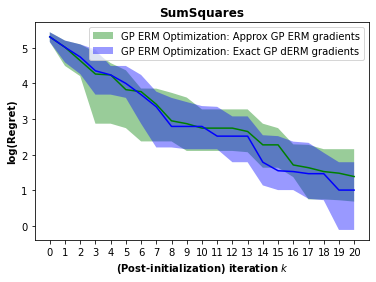

In [100]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM Optimization: Approx GP ERM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP ERM Optimization: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [ ]:
time_approx, time_exact


(152.720853805542, 628.0443766117096)